[View in Colaboratory](https://colab.research.google.com/github/rbugoo131/MLPractice/blob/master/CIFAR_10.ipynb)

In [0]:
# CIFAR-10 is a common benchmark in machine learning for image recognition.
# import library
import os
import re
import sys
import tarfile
import pickle
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Download and extract the tarball from cifar10's website.
def maybe_download_and_extract(dest_directory):
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  # Example of cifar-10 download from tensroflow
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  extracted_dir_path = os.path.join(dest_directory, cifar10_dataset_folder_path)
  print(extracted_dir_path)
  if not os.path.exists(extracted_dir_path):
    print('extracting')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [0]:
class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [0]:
def unpickle(file):
    dict = pickle.load(file, encoding='latin1')
    return dict

In [0]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + 'data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        #batch = pickle.load(file, encoding='latin1')
        batch = unpickle(file)
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [0]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [0]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [0]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

In [0]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.py')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.py')

    # load the test dataset
    with open(cifar10_dataset_folder_path + 'test_batch', mode='rb') as file:
        batch = unpickle(file)
        #batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.py')

In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)

In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.py'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [0]:
# The function is self-defined for weight and bias
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.05, shape=shape)
    return tf.Variable(initial)
    
# self-defined convolution function layer 
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# self-defined max-pooling function layer 
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    session.run(optimizer, 
                feed_dict={ x: feature_batch, 
                            y: label_batch, 
                            keep_prob: keep_probability 
                          }, 
                options=run_options
               )

In [0]:
# CIFAR-10 dataset's website
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'


# Folder for downloaded CIFAR-10 dataset
train_dir = './dataset/cifar10/'

#cifar10_dataset_folder_path = train_dir + 'cifar-10-batches-bin/'
cifar10_dataset_folder_path = 'cifar-10-batches-py/'

In [0]:
#maybe_download_and_extract(train_dir)
""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            DATA_URL,
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


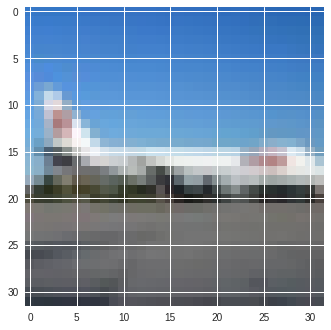

In [54]:
# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [0]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.py', mode='rb'))

In [0]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_image')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_label')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [0]:
#DNN type

with tf.name_scope('FirstConvolutionLayer'):
    W_conv1 = weight_variable([3, 3, 3, 64])
    b_conv1 = bias_variable([64])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    conv1_bn = tf.layers.batch_normalization(h_pool1)

with tf.name_scope('SecondConvolutionLayer'):
    W_conv2 = weight_variable([3, 3, 64, 128])
    b_conv2 = bias_variable([128])
    h_conv2 = tf.nn.relu(conv2d(conv1_bn, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    conv2_bn = tf.layers.batch_normalization(h_pool2)

with tf.name_scope('ThirdConvolutionLayer'):
    W_conv3 = weight_variable([5, 5, 128, 256])
    b_conv3 = bias_variable([256])
    h_conv3 = tf.nn.relu(conv2d(conv2_bn, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    conv3_bn = tf.layers.batch_normalization(h_pool3)

with tf.name_scope('ForthConvolutionLayer'):
    W_conv4 = weight_variable([5, 5, 256, 512])
    b_conv4 = bias_variable([512])
    h_conv4 = tf.nn.relu(conv2d(conv3_bn, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    conv4_bn = tf.layers.batch_normalization(h_pool4)
    
with tf.name_scope('FifthConvolutionLayer'):
    W_conv5 = weight_variable([7, 7, 512, 1024])
    b_conv5 = bias_variable([1024])
    h_conv5 = tf.nn.relu(conv2d(conv4_bn, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2(h_conv5)
    conv5_bn = tf.layers.batch_normalization(h_pool5)

with tf.name_scope('SixthConvolutionLayer'):
    W_conv6 = weight_variable([7, 7, 1024, 1024])
    b_conv6 = bias_variable([1024])
    h_conv6 = tf.nn.relu(conv2d(conv5_bn, W_conv6) + b_conv6)
    h_pool6 = max_pool_2x2(h_conv6)
    conv6_bn = tf.layers.batch_normalization(h_pool6)    
    
# flatten
flat = tf.contrib.layers.flatten(conv6_bn)  

# fully connected 1
full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=1024, activation_fn=tf.nn.relu)
full1 = tf.nn.dropout(full1, keep_prob)
full1 = tf.layers.batch_normalization(full1)

# fully connected 2
full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=512, activation_fn=tf.nn.relu)
full2 = tf.nn.dropout(full2, keep_prob)
full2 = tf.layers.batch_normalization(full2)

# fully connected 3
full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=256, activation_fn=tf.nn.relu)
full3 = tf.nn.dropout(full3, keep_prob)
full3 = tf.layers.batch_normalization(full3)    

# fully connected 4
full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=128, activation_fn=tf.nn.relu)
full4 = tf.nn.dropout(full4, keep_prob)
full4 = tf.layers.batch_normalization(full4)        

# output
out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)

In [0]:
# PSHNN Type
with tf.name_scope('SNN1'):
    W_conv1_1 = weight_variable([3, 3, 3, 64])
    b_conv1_1 = bias_variable([64])
    h_conv1_1 = tf.nn.relu(conv2d(x, W_conv1_1) + b_conv1_1)
    h_pool1_1 = max_pool_2x2(h_conv1_1)
    
    W_conv1_2 = weight_variable([3, 3, 64, 128])
    b_conv1_2 = bias_variable([128])
    h_conv1_2 = tf.nn.relu(conv2d(h_pool1_1, W_conv1_2) + b_conv1_2)
    h_pool1_2 = max_pool_2x2(h_conv1_2)
    conv1_bn = tf.layers.batch_normalization(h_pool1_2)
    
    # flatten
    flat1 = tf.contrib.layers.flatten(conv1_bn)  
    
    # fully connected 1
    full1 = tf.contrib.layers.fully_connected(inputs=flat1, num_outputs=512, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # output
    snn1_out = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=10, activation_fn=tf.nn.sigmoid)
    
with tf.name_scope('SNN2'):
    W_conv2_1 = weight_variable([5, 5, 3, 128])
    b_conv2_1 = bias_variable([128])
    h_conv2_1 = tf.nn.relu(conv2d(x, W_conv2_1) + b_conv2_1)
    h_pool2_1 = max_pool_2x2(h_conv2_1)
    
    W_conv2_2 = weight_variable([5, 5, 128, 512])
    b_conv2_2 = bias_variable([512])
    h_conv2_2 = tf.nn.relu(conv2d(h_pool2_1, W_conv2_2) + b_conv2_2)
    h_pool2_2 = max_pool_2x2(h_conv2_2)
    conv2_bn = tf.layers.batch_normalization(h_pool2_2)
    
    # flatten
    flat2 = tf.contrib.layers.flatten(conv2_bn)  
    
    # fully connected 1
    full2 = tf.contrib.layers.fully_connected(inputs=flat2, num_outputs=1024, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # output
    snn2_out = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=10, activation_fn=tf.nn.sigmoid)
    
with tf.name_scope('SNN3'):
    W_conv3_1 = weight_variable([7, 7, 3, 128])
    b_conv3_1 = bias_variable([128])
    h_conv3_1 = tf.nn.relu(conv2d(x, W_conv3_1) + b_conv3_1)
    h_pool3_1 = max_pool_2x2(h_conv3_1)
    
    W_conv3_2 = weight_variable([7, 7, 128, 256])
    b_conv3_2 = bias_variable([256])
    h_conv3_2 = tf.nn.relu(conv2d(h_pool3_1, W_conv3_2) + b_conv3_2)
    h_pool3_2 = max_pool_2x2(h_conv3_2)
    conv3_bn = tf.layers.batch_normalization(h_pool3_2)
    
    # flatten
    flat3 = tf.contrib.layers.flatten(conv3_bn)  
    
    # fully connected 1
    full3 = tf.contrib.layers.fully_connected(inputs=flat3, num_outputs=2048, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)
    
    # output
    snn3_out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=tf.nn.sigmoid)
  
#out = snn1_out
#W1 = tf.Variable(tf.truncated_normal([10],0, stddev=0.5))
#W2 = tf.Variable(tf.truncated_normal([10],0, stddev=0.5))
#out = tf.add(tf.multiply(snn1_out, W1),tf.multiply(snn2_out, W2))
#out = snn3_out

In [0]:
#global parameter setting
epochs = 10
batch_size = 1024
keep_probability = 0.7
learning_rate = 0.0001

In [0]:
# Loss and Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y))
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=snn1_out, labels=y))
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=snn2_out, labels=y))
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=snn3_out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Accuracy
correct_pred = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [81]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, loss, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

    sess.close()

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 91302.4375 Validation Accuracy: 0.101200
Epoch  1, CIFAR-10 Batch 2:  Loss: 33083.3672 Validation Accuracy: 0.112800
Epoch  1, CIFAR-10 Batch 3:  Loss: 22327.9336 Validation Accuracy: 0.157800
Epoch  1, CIFAR-10 Batch 4:  Loss: 12724.2461 Validation Accuracy: 0.160600
Epoch  1, CIFAR-10 Batch 5:  Loss:  8733.0420 Validation Accuracy: 0.156600
Epoch  2, CIFAR-10 Batch 1:  Loss:  7482.7471 Validation Accuracy: 0.163000
Epoch  2, CIFAR-10 Batch 2:  Loss:  6131.0435 Validation Accuracy: 0.144200
Epoch  2, CIFAR-10 Batch 3:  Loss:  5247.9429 Validation Accuracy: 0.155600
Epoch  2, CIFAR-10 Batch 4:  Loss:  4355.5342 Validation Accuracy: 0.159800
Epoch  2, CIFAR-10 Batch 5:  Loss:  4106.0474 Validation Accuracy: 0.163400
Epoch  3, CIFAR-10 Batch 1:  Loss:  4222.2153 Validation Accuracy: 0.163600
Epoch  3, CIFAR-10 Batch 2:  Loss:  3456.6238 Validation Accuracy: 0.155800
Epoch  3, CIFAR-10 Batch 3:  Loss:  3379.9170 Validation Accuracy: 0.156000


KeyboardInterrupt: ignored

**DNN result with initial weight [-0.5, 0.5], bias = 0.05, 6 convolution layer, out lyaer actfunction = NONE : **

Epoch 10, CIFAR-10 Batch 1:  Loss:     0.0408 Validation Accuracy: 0.727400

Epoch 10, CIFAR-10 Batch 2:  Loss:     0.0180 Validation Accuracy: 0.722000

Epoch 10, CIFAR-10 Batch 3:  Loss:     0.0310 Validation Accuracy: 0.734600

Epoch 10, CIFAR-10 Batch 4:  Loss:     0.0561 Validation Accuracy: 0.733800

Epoch 10, CIFAR-10 Batch 5:  Loss:     0.0111 Validation Accuracy: 0.737200

**SNN1 result with initial weight [-0.5, 0.5], bias = 0.05, 2 convolution layer, out lyaer actfunction = sigmoid : **
[10][1024][0.7][0.0001]

Epoch 10, CIFAR-10 Batch 1:  Loss:     1.8182 Validation Accuracy: 0.513000

Epoch 10, CIFAR-10 Batch 2:  Loss:     1.8133 Validation Accuracy: 0.518600

Epoch 10, CIFAR-10 Batch 3:  Loss:     1.7966 Validation Accuracy: 0.518200

Epoch 10, CIFAR-10 Batch 4:  Loss:     1.8009 Validation Accuracy: 0.510200

Epoch 10, CIFAR-10 Batch 5:  Loss:     1.8044 Validation Accuracy: 0.516000

**SNN2 result with initial weight [-0.5, 0.5], bias = 0.05, 2 convolution layer, out lyaer actfunction = sigmoid : **
[10][4096][0.7][0.00001]

Epoch 10, CIFAR-10 Batch 1:  Loss:     2.2376 Validation Accuracy: 0.179200

Epoch 10, CIFAR-10 Batch 2:  Loss:     2.2470 Validation Accuracy: 0.192000

Epoch 10, CIFAR-10 Batch 3:  Loss:     2.2351 Validation Accuracy: 0.201600

Epoch 10, CIFAR-10 Batch 4:  Loss:     2.2476 Validation Accuracy: 0.200000

Epoch 10, CIFAR-10 Batch 5:  Loss:     2.2406 Validation Accuracy: 0.187000

**SNN3 result with initial weight [-0.5, 0.5], bias = 0.05, 2 convolution layer, out lyaer actfunction = sigmoid : **[10][1024][0.7][0.00001]

Epoch 10, CIFAR-10 Batch 1:  Loss:     2.2281 Validation Accuracy: 0.157400

Epoch 10, CIFAR-10 Batch 2:  Loss:     2.2336 Validation Accuracy: 0.143400

Epoch 10, CIFAR-10 Batch 3:  Loss:     2.2420 Validation Accuracy: 0.155000

Epoch 10, CIFAR-10 Batch 4:  Loss:     2.2417 Validation Accuracy: 0.157800

Epoch 10, CIFAR-10 Batch 5:  Loss:     2.2403 Validation Accuracy: 0.134000

In [0]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [25]:
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

test_features, test_labels = pickle.load(open('preprocess_training.py', mode='rb'))
loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('input_image:0')
    loaded_y = loaded_graph.get_tensor_by_name('output_label:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    #loaded_out = loaded_graph.get_tensor_by_name('out:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

    # Get accuracy in batches for memory limitations
    test_batch_acc_total = 0
    test_batch_count = 0

    for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
        test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    # Print Random Samples
    #random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
    #random_test_predictions = sess.run(
    #    tf.nn.top_k(tf.nn.softmax(loaded_out), top_n_predictions),
    #    feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
    #display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.10041799363057324



**DNN result with initial weight [-0.5, 0.5], bias = 0.05, 6 convolution layer, out lyaer actfunction = NONE : **
> Testing Accuracy: 0.7239251592356688

**SNN1 result with initial weight [-0.5, 0.5], bias = 0.05, 2 convolution layer, out lyaer actfunction = sigmoid : **
> Testing Accuracy: 0.4307324840764331

**SNN2 result with initial weight [-0.5, 0.5], bias = 0.05, 2 convolution layer, out lyaer actfunction = sigmoid : **
> Testing Accuracy: 0.2770700636942675



In [26]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize    
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Running setup.py bdist_wheel for gputil ... - \ done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 11.5 GB  I Proc size: 3.4 GB
GPU RAM Free: 3037MB | Used: 8402MB | Util  73% | Total 11439MB
